In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))  # Bootstrap path to allow `services` import
from services.env import setup_project
setup_project()

✅ Project path added to sys.path: d:\portfolio_repo\arb_airdrop\src


In [2]:
import pandas as pd
from services.config import DATA_DIR

In [3]:
df = pd.read_csv(DATA_DIR/"wallet_features.csv")
print("Shape:", df.shape)
print("Churn Label Distribution:\n", df['churn_label'].value_counts())
df.head()

Shape: (100000, 12)
Churn Label Distribution:
 churn_label
1    60737
0    39263
Name: count, dtype: int64


,Unnamed: 0.1,Unnamed: 0,wallet,cumulative_balance_day_30,wallet_address,claimed_amount,balance_retention_ratio,num_transactions_30_days,total_inflow_30_days,total_outflow_30_days,days_active,churn_label
0,0,0,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,0x00000000009a41862f3b2b0c688b7c0d1940511e,4250,0.000,40,4250.0,4250.0,1,1
1,1,1,0x0000000000dfd67ffd6c24251348f7c4f933cab4,0.0,0x0000000000dfd67ffd6c24251348f7c4f933cab4,1750,0.000,2,1750.0,1750.0,1,1
2,2,2,0x0000000000e189dd664b9ab08a33c4839953852c,0.0,0x0000000000e189dd664b9ab08a33c4839953852c,2250,0.000,2,2250.0,2250.0,1,1
3,3,3,0x000000000279ef217428b1c3906ec8124784b70f,0.0,0x000000000279ef217428b1c3906ec8124784b70f,3250,0.000,2,3250.0,3250.0,1,1
4,4,4,0x0000000009572a244a6c2d06ffe7be30e3bd2aec,10.0,0x0000000009572a244a6c2d06ffe7be30e3bd2aec,625,0.016,3,635.0,625.0,2,0


Build features and target

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = [
    'claimed_amount',
    # 'cumulative_balance_day_30', removed to prevent data leakage
    'num_transactions_30_days',
    'total_inflow_30_days',
    'total_outflow_30_days',
    'days_active',
    # 'balance_retention_ratio' removed to prevent data leakage
]
target = 'churn_label'

X = df[features]
y = df[target]

In [10]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale Features - done for linearity between features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression CV ROC AUC scores:", cv_scores)
print("Mean ROC AUC:", cv_scores.mean())

lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

print("\n--- Logistic Regression ---")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:,1]))

Logistic Regression CV ROC AUC scores: [0.83995496 0.83915623 0.83954038 0.84157591 0.83527348]
Mean ROC AUC: 0.8391001898229205

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.85      0.45      0.59      7853
           1       0.73      0.95      0.82     12147

    accuracy                           0.75     20000
   macro avg       0.79      0.70      0.70     20000
weighted avg       0.77      0.75      0.73     20000

ROC AUC: 0.8446864265395453


XG Boost

In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

cv_scores_xgb = cross_val_score(xgb, X_train, y_train, cv=5, scoring='roc_auc')
print("XGBoost CV ROC AUC scores:", cv_scores_xgb)
print("Mean ROC AUC:", cv_scores_xgb.mean())

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("\n--- XGBoost ---")
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))

c:\Users\savan\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:55:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\savan\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:55:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\savan\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:55:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\savan\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:55:26] WARNING: C:\actio

XGBoost CV ROC AUC scores: [0.99234391 0.99301409 0.99194948 0.99229217 0.99287721]
Mean ROC AUC: 0.9924953720384437

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7853
           1       0.96      0.96      0.96     12147

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

ROC AUC: 0.9926702837395854


Selecting the XG boosted model as opposed to the Linear Regression

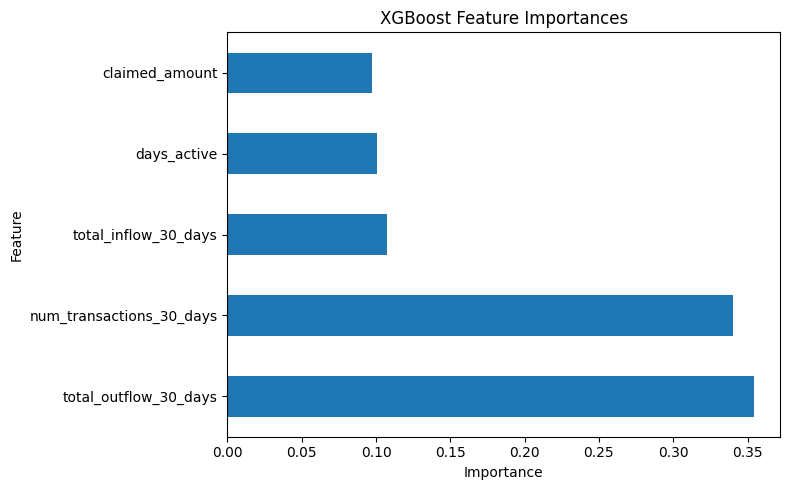

In [17]:
import matplotlib.pyplot as plt

# Plot top features
importances = xgb.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# feat_imp.plot(kind='barh', figsize=(8, 5), title='XGBoost Feature Importances')
# plt.gca().invert_yaxis()
# plt.show()

plt.figure(figsize=(8, 5))
feat_imp.plot(kind='barh')
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


c:\Users\savan\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|===================| 19939/20000 [00:41<00:00]        

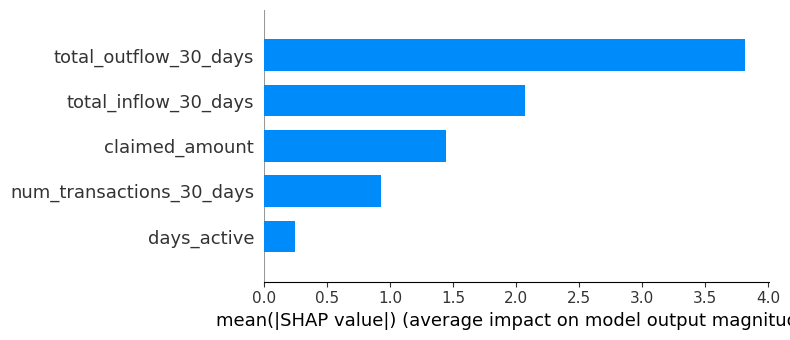

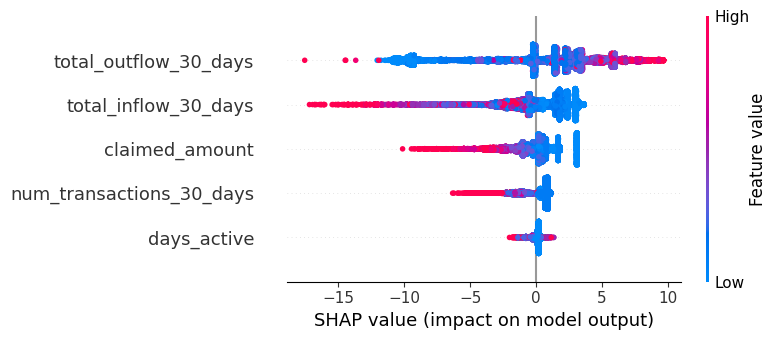

In [19]:
import shap

explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

In [ ]:
import os
os.makedirs("outputs", exist_ok=True)

X_test_out = X_test.copy()
X_test_out['true_label'] = y_test
X_test_out['predicted_churn'] = y_pred_xgb
X_test_out.to_csv:"outputs/churn_predictions.csv", index=False)

SHAP Summary Bar Plot

🔍 Interpretation:
total_outflow_30_days had the largest average impact — the model strongly relies on this to make churn predictions.

total_inflow_30_days is next — meaning receiving ARB matters too, but not as much as sending it away.

claimed_amount contributes more than number of transactions or days active.

days_active had the least influence on the model’s decisions.

SHAP Beeswarm Plot (colored summary)

✅ total_outflow_30_days
Red dots on the right → High outflow pushes toward churn

Blue dots on the left → Low outflow pushes away from churn

🔎 Insight: Wallets that send a lot of ARB are strongly likely to churn

✅ total_inflow_30_days
Red on the left → High inflow reduces churn

Blue on the right → Low inflow increases churn

🔎 Insight: Wallets receiving more ARB are less likely to churn — they’re likely accumulating or interacting more

✅ claimed_amount
Slightly more mixed, but in general:

Higher claim amounts slightly decrease churn

🔎 Insight: Bigger recipients are a bit more sticky, possibly institutional or invested users

✅ num_transactions_30_days
Not a dominant driver but:

More transactions trend slightly toward churn — maybe these users are managing exits

Very low transactions don't strongly influence the model either way

✅ days_active
Little impact, and not much separation between red and blue

🔎 Insight: Just being active a few days doesn’t explain retention as much as inflow/outflow behavior